# Error-tolerant BS-based circuit

In this notebook, we aim to present the BS-based circuit which is an alternative to Mach-Zehnder interferometers usually exploited because it is capable of implementing arbitrary transfer matrices. BS-based circuit seems to be tolerant of manufacturing errors and losses due to its design according to Fldzhyan et al (2020) Optimal design of error-tolerant reprogrammable multiport interferometers. Optics Letters, 45(9):2632–2635

## Introduction 

### Parameters

The variable phase shifts $\phi$ are used to reconfigure the interferometer and have required ranges from 0 to 2π. The variation of the $\phi$ parameter allows us to obtain different transfer matrices U each time. These matrices will then be compared to the unitary matrix U0 of the BS-based with the calculation of the fidelity. 

Parameters $\alpha$ describe errors caused by the imbalances of the static BSs due to non-ideal realization. To analyze the error tolerance of the BS, we vary the $\alpha$ values to explore the different values of associated infidelity. 

We are not looking for fidelity value because for this cricuit, no analytical solution is known to derive phase shifts that maximize the fidelity. [1]
Consequently, the aim of this program is to minimize the infidelity.

## Perceval implementation

### Initialisation

In [1]:
from multiprocessing import Pool, TimeoutError
import logging
import datetime
import time
import numpy as np
from scipy.optimize import basinhopping
import random
import perceval as pcvl
import perceval.lib.phys as phys
import os
import argparse
import math
from tqdm import tqdm

We define all parameters used in this program :

In [2]:
N=5
n_try=3
n_iter=1
n_process=8
angle_min=-15
angle_max=30
angle_step=30
n_unitary=2
logfilebs='bsbased-opt'
logfilemzi='mzibased-opt'

# 1- BS-based

### Circuit construction :  BS-based 

We start by describing the circuit as defined by the paper above [1]. The circuit is built with a single static beam-splitter and a variable phase shift. There is also a phase at the beginning of each mode to (to add).

In [3]:
bs = pcvl.Circuit.generic_interferometer(N,
                                         lambda idx : phys.BS(theta=pcvl.P("theta_%d"%idx))//(0, phys.PS(phi=np.pi*2*random.random())),
                                         shape="rectangle",
                                         depth = 2*N,
                                         phase_shifter_fun_gen=lambda idx: phys.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)


# Minimizing infidelity

We start by defining a function which calculate the infidelity from the fidelity. The fidelity evaluate the performance of multiport interferometers $F=\frac{\lvert \mathrm{Tr} ({U}^{\dagger} U0) \rvert²}{N\mathrm{Tr}({U}^{\dagger} U)}$. it compares the target unitary matrix U0 and the actual transfer matrix U realized by the interferometer, where N is the size of the matrices.

In [4]:
def infidelity(c, U0, params, params_value):
    for idx, p in enumerate(params_value):
        params[idx].set_value(p)
    U = c.compute_unitary(False)
    U_dag = np.transpose(np.conjugate(U))
    f = abs(np.trace(U_dag @ U0)) ** 2 / (c.m * np.trace(U_dag @ U))
    return 1 - abs(f)

### Basinhopping algorithm

Then, we want to find phis $\phi$ matching U0 by minimizing the infidelity. To do so, we used a numerical optimization algorithm based on the basinhopping algorithm to minimize infidelity 1-F. The algorithm was searching for a global minimum of infidelity 1 − F over the space of phase-shifts. [1]

In [5]:
def calculate_angle(index_unitary,U0,alpha):
    start = time.time()
    c = pcvl.Circuit.generic_interferometer(N,
                                            lambda idx: (phys.BS(theta=(45+alpha)/180*np.pi)
                                                            // (0, phys.PS(phi=pcvl.P("phi_m%d" % idx)))),
                                            depth=2*N,
                                            phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx))
                                            )
    params = c.get_parameters()

    # goal is to find phis matching U0 - by minimizing fidelity
    infidelities = []

    for _ in range(n_try):
        init_params = np.random.randn(len(params))
        res = basinhopping(lambda x: infidelity(c, U0, params, x), init_params, stepsize=0.1, niter=n_iter)
        infidelities.append(res.fun)
    return min(infidelities)

Based on the calculate_angle() function, we get the minimal infidelity value for each angle. Higher n_iter is, more the basinhopping algorithm explores the infidelity values.

Now, we have an infidelity value for each angle and a list of those infidelities for each unitarian matrix U0 compared to the random transfer matrix U from BS-based circuit.

In [6]:
from tqdm.notebook import tqdm_notebook

n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff)
    U0 = pcvl.Matrix.random_unitary(N)
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1

    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1), leave=False):
        l_infidelities.append(calculate_angle(index_unitary, U0, alpha))
    return l_infidelities

try:
    os.remove("%s-%d.log" % (logfilebs,N))
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilebs,N), "a") as f:
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")                
        f.write("\t".join(["%g"%inf for inf in result]))
        f.write("\n")

Unitary progress bar:   0%|          | 0/2 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/3 [00:00<?, ?it/s]

Angle progress bar unitary 2:   0%|          | 0/3 [00:00<?, ?it/s]

# Data process

In this section, we treat the previously collected infidelity values as a function of alpha. What could be better than a graph to illustrate our results?  

This is the data collected : 
Each lign starts with date and hour of collect and then, we have each minimal infidelity per alpha.
A lign is a unitarian matrix.

In [18]:
with open("bsbased-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

2022-05-20 08:22:21	0.119608	7.03826e-10	0.802393

2022-05-20 08:25:49	0.00692732	1.32985e-09	0.788542



### Graph of the infidelity according to alpha in degree : BS-based

We want to plot the infidelity graph as a function of the alpha angle values. To do this, we compute the average of the infidelities by unit matrix U0. We put this average in a list.

In [19]:
file = open("%s-%d.log" % (logfilebs,N)).readlines()
for i in range (len (file)):
    file[i] = file[i].split("\t")

for x in range (len(file)):
    for i in range(1):
        file[x].pop(0) 

final_file = [ ]
summ = 0
avrg = []

for y in range (len(file[0])):
    L = [ ]
    summ = 0.0
    for x in range(len(file)):
        L.append(float(file[x][y].replace("\n","")))
        
    for x in L:
        summ+=float(x)
    avrg.append(summ/len(L))
    final_file.append(L)

Text(0, 0.5, 'infidelity 1-F')

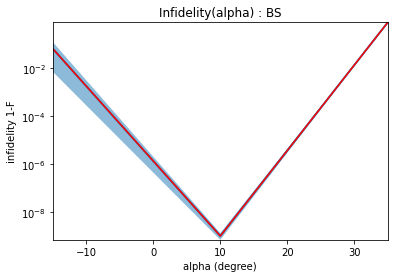

In [20]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(avrg))
Lmin=[min(l) for l in final_file]
Lmax=[max(l) for l in final_file]

#plot
"""
plt.plot(x,moy,'r')
plt.plot(x,Lmin,'b--')
plt.plot(x,Lmax,'y--')
"""
fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,avrg,linewidth=2)

ax.set(xlim=(-15, 35),
       ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,avrg,'r')
plt.title("Infidelity(alpha) : BS")
plt.xlabel('alpha (degree)')
plt.ylabel('infidelity 1-F')


# 2- MZI-based

### Circuit construction : MZI-based

Now, let's do the same for MZI-based. This circuit is built with composition of beam-splitters and phase-shifters

In [10]:
def mzi(P1,P2):
    mz= (pcvl.Circuit(2, name="mzi")
       .add((0, 1), phys.BS(theta=(45)/180*np.pi))
       .add(0, phys.PS(P1))
       .add((0, 1), phys.BS(theta=(45)/180*np.pi))
       .add(0, phys.PS(P2)))
    return mz

In [11]:
c = pcvl.Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx)),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx)))
pcvl.pdisplay(c)

## Minimizing infidelity

### Basinhopping algorithm

In [12]:
def calculate_angle(index_unitary, U0, alpha):
    start = time.time()
    c = pcvl.Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx)),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx)))
    params = c.get_parameters()

    # goal is to find phis matching U0 - by minimizing fidelity
    infidelities = []

    for _ in range(n_try):
        init_params = np.random.randn(len(params))
        res = basinhopping(lambda x: infidelity(c, U0, params, x), init_params, stepsize=0.1, niter=n_iter)
        infidelities.append(res.fun)
    
    return min(infidelities)

In [13]:
n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff)
    U0 = pcvl.Matrix.random_unitary(N)
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1
    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1)):
        l_infidelities.append(calculate_angle(index_unitary, U0, alpha))
    return l_infidelities

try:
    os.remove("%s-%d.log" % (logfilemzi,N))
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilemzi,N), "a") as f:
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")                
        f.write("\t".join(["%g"%inf for inf in result]))
        f.write("\n")

Unitary progress bar:   0%|          | 0/2 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/3 [00:00<?, ?it/s]

Angle progress bar unitary 2:   0%|          | 0/3 [00:00<?, ?it/s]

# Data process

In [24]:
with open("mzibased-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

2022-05-20 08:29:49	4.0174e-10	1.87204e-10	1.219e-10

2022-05-20 08:34:36	3.10296e-10	1.2232e-10	3.68158e-10



In [22]:
file = open("mzibased-opt-5.log").readlines()
for i in range (len (file)):
    file[i] = file[i].split("\t")

for x in range (len(file)):
    for i in range(1):
        file[x].pop(0) 

final_file = [ ]
summ = 0
avrg = []

for y in range (len(file[0])):
    L = [ ]
    somme = 0.0
    for x in range(len(file)):
        L.append(float(file[x][y].replace("\n","")))
        
    for x in L:
        summ+=float(x)
    avrg.append(summ/len(L))
    final_file.append(L)

### Graph of the infidelity according to alpha in degree : MZI-based

Text(0, 0.5, 'infidelity 1-F')

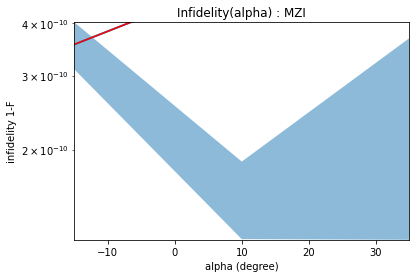

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(avrg))
Lmin=[min(l) for l in final_file]
Lmax=[max(l) for l in final_file]

#plot
"""
plt.plot(x,moy,'r')
plt.plot(x,Lmin,'b--')
plt.plot(x,Lmax,'y--')
"""
fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,avrg,linewidth=2)

ax.set(xlim=(-15, 35),
       ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,avrg,'r')
plt.title("Infidelity(alpha) : MZI")
plt.xlabel('alpha (degree)')
plt.ylabel('infidelity 1-F')


# Our results

The MZI-based interferometers are equally sensitive to both positive and negative values of α with the acceptable range of errors is of the order of several degrees. For the BS-based interferometers, infidelity behaves radically different: while at α < 0 the performance of the two are comparable, at α > 0 the BS-based interferometers provide perfect fidelity for α as
large as ∼ 20 degrees — several times larger than for the MZI-based interferometers.

[graphes que nous obtenons avec N=12 et N=5]

[1] Suren A Fldzhyan, M Yu Saygin, and Sergei P Kulik. Optimal design of error-tolerant reprogrammable multiport interferometers. Optics Letters, 45(9):2632–2635, 2020.